# Forecast with a Deep Learning Network.

## Contents:
- [DL from scratch](#from-scratch): 
- [Use Pytorch](#use-pytorch)

# DL from scratch<a id='from-scratch'></a>
**Goal: Make a deep learning network similar to my [Bike-Sharing-Prediction project](https://github.com/viktor-begun/Deep_Learning_Bike_Sharing) and use it to forecast the price movement.**

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data_path = 'EURUSD_1H_2016.txt'
df = pd.read_table(data_path,sep=',')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8783 entries, 0 to 8782
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Local time  8783 non-null   object 
 1   Open        8783 non-null   float64
 2   High        8783 non-null   float64
 3   Low         8783 non-null   float64
 4   Close       8783 non-null   float64
 5   Volume      8783 non-null   float64
dtypes: float64(5), object(1)
memory usage: 411.8+ KB


In [4]:
df.head()

,Local time,Open,High,Low,Close,Volume
0,01.01.2016 00:00:00.000,1.08564,1.08564,1.08564,1.08564,0.0
1,01.01.2016 01:00:00.000,1.08564,1.08564,1.08564,1.08564,0.0
2,01.01.2016 02:00:00.000,1.08564,1.08564,1.08564,1.08564,0.0
3,01.01.2016 03:00:00.000,1.08564,1.08564,1.08564,1.08564,0.0
4,01.01.2016 04:00:00.000,1.08564,1.08564,1.08564,1.08564,0.0


**(!) Exclude non-trading hours.**

In [5]:
#df = df[df.Volume!=0]
#df.reset_index(inplace=True)
#df

In [6]:
df.Low

0       1.08564
1       1.08564
2       1.08564
3       1.08564
4       1.08564
         ...   
8778    1.05150
8779    1.05150
8780    1.05150
8781    1.05150
8782    1.05150
Name: Low, Length: 8783, dtype: float64

**(!) Add a new column `High` minus `Low` - [`HML`](https://www.investopedia.com/terms/h/high_minus_low.asp)**

In [7]:
df['HML'] = df.High - df.Low

In [8]:
df.head()

,Local time,Open,High,Low,Close,Volume,HML
0,01.01.2016 00:00:00.000,1.08564,1.08564,1.08564,1.08564,0.0,0.0
1,01.01.2016 01:00:00.000,1.08564,1.08564,1.08564,1.08564,0.0,0.0
2,01.01.2016 02:00:00.000,1.08564,1.08564,1.08564,1.08564,0.0,0.0
3,01.01.2016 03:00:00.000,1.08564,1.08564,1.08564,1.08564,0.0,0.0
4,01.01.2016 04:00:00.000,1.08564,1.08564,1.08564,1.08564,0.0,0.0


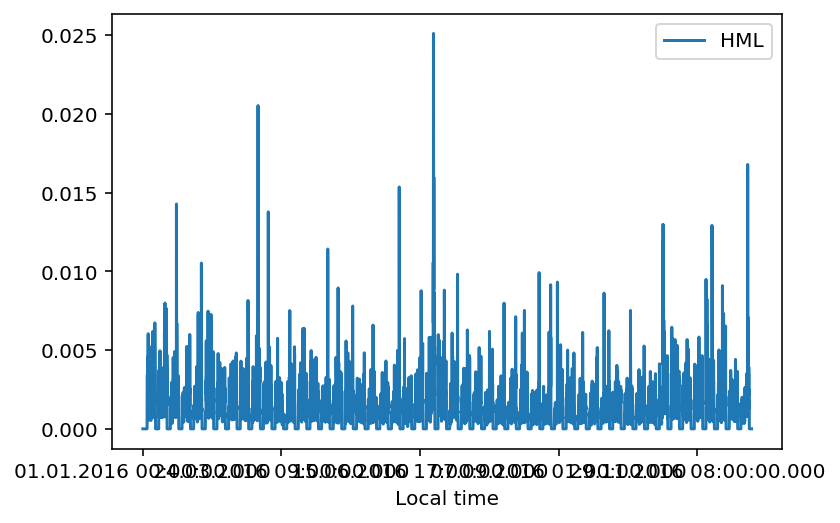

In [9]:
df.plot(x='Local time', y='HML');

## Dummy variables
We do not have dummy variables yet, but **we drop the `Local time`**, because it is a string, while our Neural Network accepts only numbers. It should be ok, because we keep the index, which can be used later to reconstruct the date and time. 

In [10]:
#dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
#for each in dummy_fields:
#    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
#    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['Local time']
df_no_time = df.drop(fields_to_drop, axis=1)
df_no_time.head()

,Open,High,Low,Close,Volume,HML
0,1.08564,1.08564,1.08564,1.08564,0.0,0.0
1,1.08564,1.08564,1.08564,1.08564,0.0,0.0
2,1.08564,1.08564,1.08564,1.08564,0.0,0.0
3,1.08564,1.08564,1.08564,1.08564,0.0,0.0
4,1.08564,1.08564,1.08564,1.08564,0.0,0.0


## Scaling target variables
To make training the network easier, we'll standardize each of the continuous variables. That is, we'll shift and scale the variables such that they have zero mean and a standard deviation of 1.

The scaling factors are saved so we can go backwards when we use the network for predictions.

In [11]:
quant_features = ['Open', 'High', 'Low', 'Close', 'Volume', 'HML']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = df_no_time[each].mean(), df_no_time[each].std()
    scaled_features[each] = [mean, std]
    df_no_time.loc[:, each] = (df_no_time[each] - mean)/std

df_no_time.head()

,Open,High,Low,Close,Volume,HML
0,-0.839744,-0.864742,-0.816484,-0.839569,-0.743981,-0.852004
1,-0.839744,-0.864742,-0.816484,-0.839569,-0.743981,-0.852004
2,-0.839744,-0.864742,-0.816484,-0.839569,-0.743981,-0.852004
3,-0.839744,-0.864742,-0.816484,-0.839569,-0.743981,-0.852004
4,-0.839744,-0.864742,-0.816484,-0.839569,-0.743981,-0.852004


## Splitting the data into training, testing, and validation sets.

We'll save the data for the last approximately 21 days to use as a test set after we've trained the network. We'll use this set to make predictions and compare them with the actual values.

In [12]:
# Save data for approximately the last 21 days 
test_df = df_no_time[-21*24:]

# Now remove the test data from the data set 
df_no_time = df_no_time[:-21*24]

# Separate the data into features and targets
target_fields = ['HML', 'Volume']
features, targets = df_no_time.drop(target_fields, axis=1), df_no_time[target_fields]
test_features, test_targets = test_df.drop(target_fields, axis=1), test_df[target_fields]

In [13]:
targets.head()

,HML,Volume
0,-0.852004,-0.743981
1,-0.852004,-0.743981
2,-0.852004,-0.743981
3,-0.852004,-0.743981
4,-0.852004,-0.743981


In [14]:
features.head()

,Open,High,Low,Close
0,-0.839744,-0.864742,-0.816484,-0.839569
1,-0.839744,-0.864742,-0.816484,-0.839569
2,-0.839744,-0.864742,-0.816484,-0.839569
3,-0.839744,-0.864742,-0.816484,-0.839569
4,-0.839744,-0.864742,-0.816484,-0.839569


In [15]:
# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

In [25]:
train_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6839 entries, 0 to 6838
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    6839 non-null   float64
 1   High    6839 non-null   float64
 2   Low     6839 non-null   float64
 3   Close   6839 non-null   float64
dtypes: float64(4)
memory usage: 213.8 KB


In [26]:
train_features.shape[1]

4

In [16]:
targets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8279 entries, 0 to 8278
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   HML     8279 non-null   float64
 1   Volume  8279 non-null   float64
dtypes: float64(2)
memory usage: 129.5 KB


In [17]:
val_targets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 6839 to 8278
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   HML     1440 non-null   float64
 1   Volume  1440 non-null   float64
dtypes: float64(2)
memory usage: 22.6 KB


In [18]:
from DL_Forecast_Network import NeuralNetwork

In [19]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## Unit tests
Run these unit tests to check the correctness of your network implementation. This will help you be sure your network was implemented correctly befor you starting trying to train it. These tests must all be successful to pass the project.

In [20]:
import unittest

inputs = np.array([[0.5, -0.2, 0.1]])
targets = np.array([[0.4]])
test_w_i_h = np.array([[0.1, -0.2],
                       [0.4, 0.5],
                       [-0.3, 0.2]])
test_w_h_o = np.array([[0.3],
                       [-0.1]])

class TestMethods(unittest.TestCase):
    
    ##########
    # Unit tests for data loading
    ##########
    
    def test_data_path(self):
        # Test that file path to dataset has been unaltered
        self.assertTrue(data_path.lower() == 'eurusd_1h_2016.txt') #'bike-sharing-dataset/hour.csv')
        
    def test_data_loaded(self):
        # Test that data frame loaded
        self.assertTrue(isinstance(df, pd.DataFrame))
    
    ##########
    # Unit tests for network functionality
    ##########

    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # Test that the activation function is a sigmoid
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        # Test that weights are updated correctly on training
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        network.train(inputs, targets)
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    np.array([[ 0.37275328], 
                                              [-0.03172939]])))
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    np.array([[ 0.10562014, -0.20185996], 
                                              [0.39775194, 0.50074398], 
                                              [-0.29887597, 0.19962801]])))

    def test_run(self):
        # Test correctness of run method
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()

        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)


.....
----------------------------------------------------------------------
Ran 5 tests in 0.013s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

## Training the network

In [27]:
batch = np.random.choice(train_features.index, size=128)
X, y = train_features.iloc[batch].values, train_targets.iloc[batch]['HML']
print(X,y)

[[ 0.70337494  0.70210274  0.71466994  0.72326052]
 [ 0.97101394  0.9475844   0.99240862  0.970885  ]
 [ 0.35744155  0.33348045  0.37946808  0.35741531]
 [-1.28753967 -1.19858096 -1.28417066 -1.21979288]
 [ 1.99003946  2.09703026  1.97686455  2.10196973]
 [ 0.37062376  0.37026272  0.20548236  0.28392676]
 [-0.60965401 -0.61606179 -0.62055079 -0.61910382]
 [ 1.03293043  1.01555163  1.01156301  1.00323594]
 [ 0.97620694  1.10350923  0.99759627  1.08910572]
 [ 0.0099103   0.02682828 -0.03195229 -0.05276266]
 [ 0.74252214  0.74728096  0.74419963  0.76839208]
 [ 0.13214543  0.110388    0.07180066  0.05427502]
 [ 0.99018808  0.98356705  1.00278392  1.00004079]
 [ 0.52601417  0.51859121  0.49559158  0.52116699]
 [-0.86770595 -0.8647419  -0.87155313 -0.88150589]
 [ 0.74531837  0.7216933   0.76694547  0.74522721]
 [ 1.17873377  1.18866817  1.19831833  1.20812523]
 [ 0.36742808  0.36786387  0.38505478  0.38577231]
 [ 0.33666956  0.31269047  0.35871749  0.33664681]
 [ 0.82441168  0.84243509  0.82

In [35]:
import sys

####################
### Set the hyperparameters in you myanswers.py file ###
####################

#from my_answers import iterations, learning_rate, hidden_nodes, output_nodes
from DL_Forecast_Network import iterations, learning_rate, hidden_nodes, output_nodes


N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.iloc[batch].values, train_targets.iloc[batch]['HML']
                             
    network.train(X, y)
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features).T, train_targets['HML'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['HML'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

Progress: 100.0% ... Training loss: 0.030 ... Validation loss: 0.091

In [36]:
print(N_i, hidden_nodes, output_nodes)

4 30 1


iterations = 4000 learning_rate = 0.3 hidden_nodes = 30 output_nodes = 1
Training loss = 0.03074253515274599 
Validation loss = 0.09178273905635606


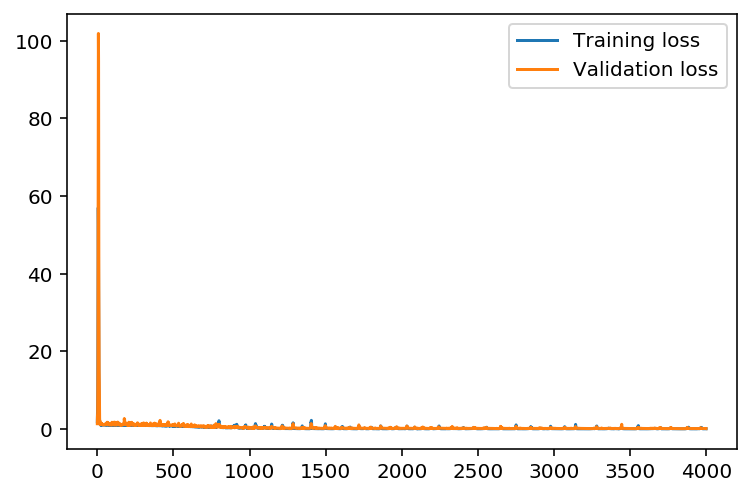

In [37]:
print('iterations =',iterations,'learning_rate =',learning_rate,'hidden_nodes =',hidden_nodes,'output_nodes =',output_nodes)
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()
print('Training loss =',losses['train'][-1],'\nValidation loss =',losses['validation'][-1])

In [38]:
NeuralNetwork

DL_Forecast_Network.NeuralNetwork

## Check out the predictions

iterations = 4000 learning_rate = 0.3 hidden_nodes = 30 output_nodes = 1


/home/vb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


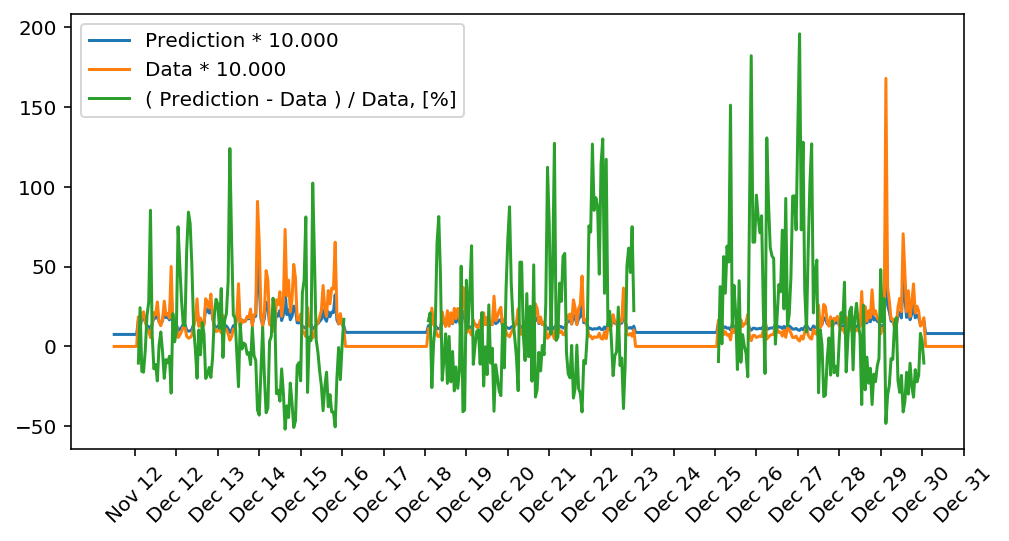

In [39]:
print('iterations =',iterations,'learning_rate =',learning_rate,'hidden_nodes =',hidden_nodes,'output_nodes =',output_nodes)

fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['HML']
predictions = network.run(test_features).T*std + mean
#ax.plot(predictions[0], label='Prediction')
#ax.plot((test_targets['HML']*std + mean).values, label='Data')
#
f1 = predictions[0]
f2 = (test_targets['HML']*std + mean).values
diff = 100*(f1 - f2) / f2
ax.plot(f1*10000, label='Prediction * 10.000')
ax.plot(f2*10000, label='Data * 10.000')
ax.plot(diff, label='( Prediction - Data ) / Data, [%]')
#

ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(df.iloc[test_df.index]['Local time'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

**=============================**

iterations = 10000 learning_rate = 0.3 hidden_nodes = 30 output_nodes = 1


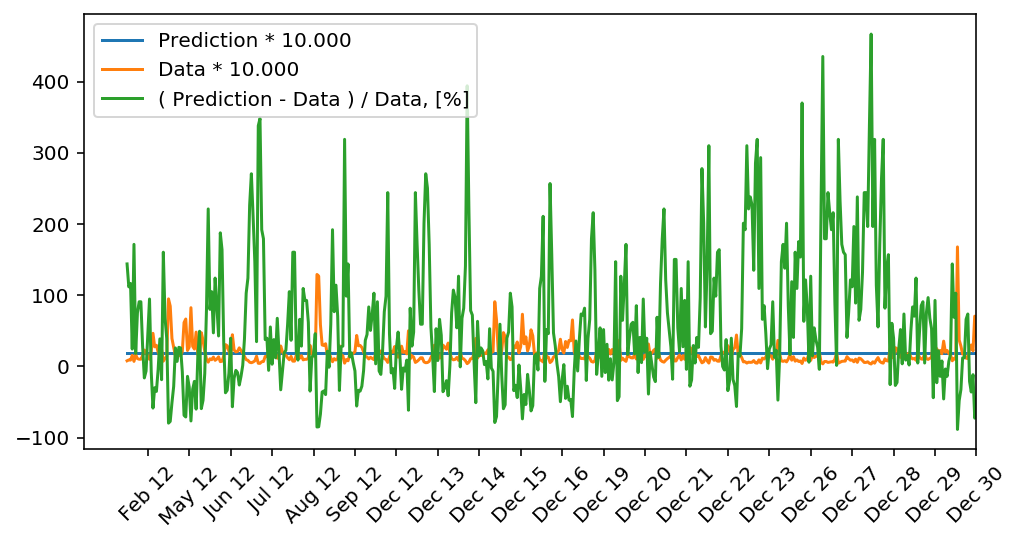

In [44]:
print('iterations =',iterations,'learning_rate =',learning_rate,'hidden_nodes =',hidden_nodes,'output_nodes =',output_nodes)

fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['HML']
predictions = network.run(test_features).T*std + mean
#ax.plot(predictions[0], label='Prediction')
#ax.plot((test_targets['HML']*std + mean).values, label='Data')
#
f1 = predictions[0]
f2 = (test_targets['HML']*std + mean).values
diff = 100*(f1 - f2) / f2
ax.plot(f1*10000, label='Prediction * 10.000')
ax.plot(f2*10000, label='Data * 10.000')
ax.plot(diff, label='( Prediction - Data ) / Data, [%]')
#

ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(df.iloc[test_df.index]['Local time'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

**(!) The model is not learning with `iterations = 10000 learning_rate = 0.3 hidden_nodes = 30 output_nodes = 1` without non-trading hours! Why?**

**(!) Below is the result with non-trading hours.**

iterations = 10000 learning_rate = 0.3 hidden_nodes = 30 output_nodes = 1


/home/vb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


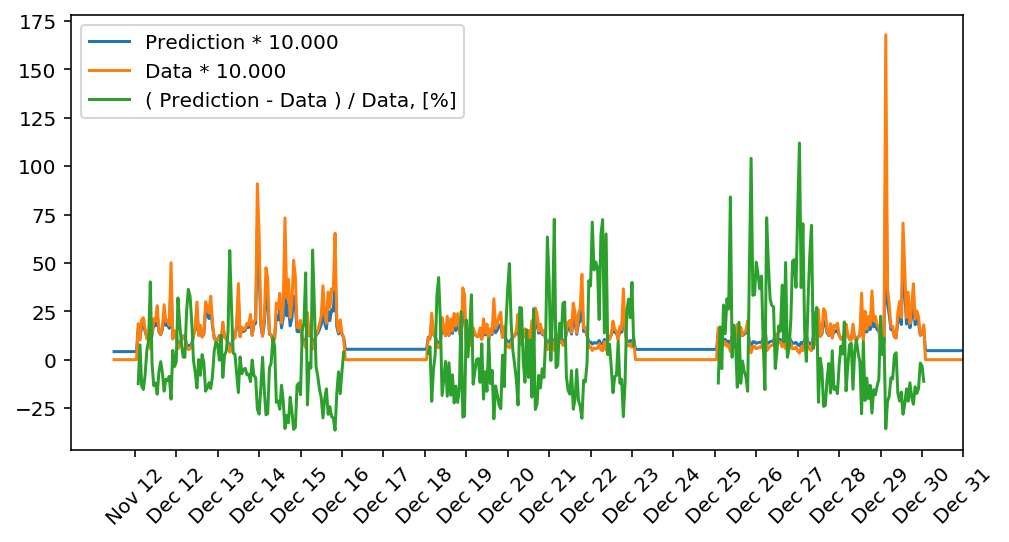

In [26]:
print('iterations =',iterations,'learning_rate =',learning_rate,'hidden_nodes =',hidden_nodes,'output_nodes =',output_nodes)

fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['HML']
predictions = network.run(test_features).T*std + mean
#ax.plot(predictions[0], label='Prediction')
#ax.plot((test_targets['HML']*std + mean).values, label='Data')
#
f1 = predictions[0]
f2 = (test_targets['HML']*std + mean).values
diff = 100*(f1 - f2) / f2
ax.plot(f1*10000, label='Prediction * 10.000')
ax.plot(f2*10000, label='Data * 10.000')
ax.plot(diff, label='( Prediction - Data ) / Data, [%]')
#

ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(df.iloc[test_df.index]['Local time'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

**(!) The prediction for `iterations = 10000 learning_rate = 0.3 hidden_nodes = 30 output_nodes = 1` can have an error from `-25%` to `100%`.**

# Use Pytorch<a id='use-pytorch'></a>
**Goal: use the functionality of [Pytorch](https://pytorch.org/docs/stable/nn.html).**
1. Try the open source library, see the [towardsdatascience post](https://towardsdatascience.com/introducing-pytorch-forecasting-64de99b9ef46), the [library documentation](https://pytorch-forecasting.readthedocs.io/en/latest/) and the [GitHub repository](https://github.com/jdb78/pytorch-forecasting).

## Implement [Demand forecasting with the Temporal Fusion Transformer](https://pytorch-forecasting.readthedocs.io/en/latest/tutorials/stallion.html) for HML prediction:

In [1]:
import os
import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

os.chdir("../../..")

In [2]:
#!pip install pytorch-lightning

In [3]:
#pip install pytorch-forecasting

In [4]:
import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

## Load Kaggle data

In [7]:
#!pip install pyarrow

In [9]:
#!pip install fastparquet

In [10]:
from pytorch_forecasting.data.examples import get_stallion_data

data = get_stallion_data()

# add time index
data["time_idx"] = data["date"].dt.year * 12 + data["date"].dt.month
data["time_idx"] -= data["time_idx"].min()

# add additional features
data["month"] = data.date.dt.month.astype(str).astype("category")  # categories have be strings
data["log_volume"] = np.log(data.volume + 1e-8)
data["avg_volume_by_sku"] = data.groupby(["time_idx", "sku"], observed=True).volume.transform("mean")
data["avg_volume_by_agency"] = data.groupby(["time_idx", "agency"], observed=True).volume.transform("mean")

# we want to encode special days as one variable and thus need to first reverse one-hot encoding
special_days = [
    "easter_day",
    "good_friday",
    "new_year",
    "christmas",
    "labor_day",
    "independence_day",
    "revolution_day_memorial",
    "regional_games",
    "fifa_u_17_world_cup",
    "football_gold_cup",
    "beer_capital",
    "music_fest",
]
data[special_days] = data[special_days].apply(lambda x: x.map({0: "-", 1: x.name})).astype("category")
data.sample(10, random_state=521)

,agency,sku,volume,date,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,...,football_gold_cup,beer_capital,music_fest,discount_in_percent,timeseries,time_idx,month,log_volume,avg_volume_by_sku,avg_volume_by_agency
291,Agency_25,SKU_03,0.5076,2013-01-01,492612703,718394219,25.845238,1264.162234,1152.473405,111.688829,...,-,-,-,8.835008,228,0,1,-0.678062,1225.306376,99.650400
871,Agency_29,SKU_02,8.7480,2015-01-01,498567142,762225057,27.584615,1316.098485,1296.804924,19.293561,...,-,-,-,1.465966,177,24,1,2.168825,1634.434615,11.397086
19532,Agency_47,SKU_01,4.9680,2013-09-01,454252482,789624076,30.665957,1269.250000,1266.490490,2.759510,...,-,-,-,0.217413,322,8,9,1.603017,2625.472644,48.295650
2089,Agency_53,SKU_07,21.6825,2013-10-01,480693900,791658684,29.197727,1193.842373,1128.124395,65.717978,...,-,beer_capital,-,5.504745,240,9,10,3.076505,38.529107,2511.035175
9755,Agency_17,SKU_02,960.5520,2015-03-01,515468092,871204688,23.608120,1338.334248,1232.128069,106.206179,...,-,-,music_fest,7.935699,259,26,3,6.867508,2143.677462,396.022140
7561,Agency_05,SKU_03,1184.6535,2014-02-01,425528909,734443953,28.668254,1369.556376,1161.135214,208.421162,...,-,-,-,15.218151,21,13,2,7.077206,1566.643589,1881.866367
19204,Agency_11,SKU_05,5.5593,2017-08-01,623319783,1049868815,31.915385,1922.486644,1651.307674,271.178970,...,-,-,-,14.105636,17,55,8,1.715472,1385.225478,109.699200
8781,Agency_48,SKU_04,4275.1605,2013-03-01,509281531,892192092,26.767857,1761.258209,1546.059670,215.198539,...,-,-,music_fest,12.218455,151,2,3,8.360577,1757.950603,1925.272108
2540,Agency_07,SKU_21,0.0000,2015-10-01,544203593,761469815,28.987755,0.000000,0.000000,0.000000,...,-,-,-,0.000000,300,33,10,-18.420681,0.000000,2418.719550
12084,Agency_21,SKU_03,46.3608,2017-04-01,589969396,940912941,32.478910,1675.922116,1413.571789,262.350327,...,-,-,-,15.654088,181,51,4,3.836454,2034.293024,109.381800


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21000 entries, 0 to 6650
Data columns (total 31 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   agency                            21000 non-null  category      
 1   sku                               21000 non-null  category      
 2   volume                            21000 non-null  float64       
 3   date                              21000 non-null  datetime64[ns]
 4   industry_volume                   21000 non-null  int64         
 5   soda_volume                       21000 non-null  int64         
 6   avg_max_temp                      21000 non-null  float64       
 7   price_regular                     21000 non-null  float64       
 8   price_actual                      21000 non-null  float64       
 9   discount                          21000 non-null  float64       
 10  avg_population_2017               21000 non-nul

In [12]:
data.head()

,agency,sku,volume,date,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,...,football_gold_cup,beer_capital,music_fest,discount_in_percent,timeseries,time_idx,month,log_volume,avg_volume_by_sku,avg_volume_by_agency
0,Agency_22,SKU_01,52.2720,2013-01-01,492612703,718394219,25.845238,1168.903668,1069.166193,99.737475,...,-,-,-,8.532566,0,0,1,3.956461,2613.377501,103.805460
238,Agency_37,SKU_04,0.0000,2013-01-01,492612703,718394219,26.505000,1852.273642,1611.466298,240.807344,...,-,-,-,13.000635,5,0,1,-18.420681,1361.511918,0.549900
237,Agency_59,SKU_03,812.9214,2013-01-01,492612703,718394219,22.219737,1270.795012,1197.184260,73.610752,...,-,-,-,5.792496,9,0,1,6.700634,1225.306376,2041.909586
236,Agency_11,SKU_01,316.4400,2013-01-01,492612703,718394219,25.360000,1176.155397,1082.757488,93.397909,...,-,-,-,7.940950,14,0,1,5.757134,2613.377501,125.690220
235,Agency_05,SKU_05,420.9093,2013-01-01,492612703,718394219,24.079012,1327.003396,1207.822992,119.180404,...,-,-,-,8.981168,22,0,1,6.042417,1179.728165,1638.463500


In [25]:
data.describe()

,volume,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,avg_population_2017,avg_yearly_household_income_2017,discount_in_percent,timeseries,time_idx,log_volume,avg_volume_by_sku,avg_volume_by_agency
count,21000.000000,2.100000e+04,2.100000e+04,21000.000000,21000.000000,21000.000000,21000.000000,2.100000e+04,21000.000000,21000.000000,21000.00000,21000.000000,21000.000000,21000.000000,21000.000000
mean,1492.403982,5.439214e+08,8.512000e+08,28.612404,1451.536344,1267.347450,184.374146,1.045065e+06,151073.494286,10.574884,174.50000,29.500000,2.464118,1492.403982,1492.403982
std,2711.496882,6.288022e+07,7.824340e+07,3.972833,683.362417,587.757323,257.469968,9.291926e+05,50409.593114,9.590813,101.03829,17.318515,8.178218,1051.790829,1328.239698
min,0.000000,4.130518e+08,6.964015e+08,16.731034,0.000000,-3121.690141,0.000000,1.227100e+04,90240.000000,0.000000,0.00000,0.000000,-18.420681,0.000000,0.000000
25%,8.272388,5.090553e+08,7.890880e+08,25.374816,1311.547158,1178.365653,54.935108,6.018900e+04,110057.000000,3.749628,87.00000,14.750000,2.112923,932.285496,113.420250
50%,158.436000,5.512000e+08,8.649196e+08,28.479272,1495.174592,1324.695705,138.307225,1.232242e+06,131411.000000,8.948990,174.50000,29.500000,5.065351,1402.305264,1730.529771
75%,1774.793475,5.893715e+08,9.005551e+08,31.568405,1725.652080,1517.311427,272.298630,1.729177e+06,206553.000000,15.647058,262.00000,44.250000,7.481439,2195.362302,2595.316500
max,22526.610000,6.700157e+08,1.049869e+09,45.290476,19166.625000,4925.404000,19166.625000,3.137874e+06,247220.000000,226.740147,349.00000,59.000000,10.022453,4332.363750,5884.717375


## Load and compare to our trading data

In [15]:
!pwd

/home


In [21]:
data_path = '/home/vb/Programming/ML_Trading/EURUSD_1H_2016.txt'
df = pd.read_table(data_path,sep=',')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8783 entries, 0 to 8782
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Local time  8783 non-null   object 
 1   Open        8783 non-null   float64
 2   High        8783 non-null   float64
 3   Low         8783 non-null   float64
 4   Close       8783 non-null   float64
 5   Volume      8783 non-null   float64
dtypes: float64(5), object(1)
memory usage: 411.8+ KB


In [22]:
df.head()

,Local time,Open,High,Low,Close,Volume
0,01.01.2016 00:00:00.000,1.08564,1.08564,1.08564,1.08564,0.0
1,01.01.2016 01:00:00.000,1.08564,1.08564,1.08564,1.08564,0.0
2,01.01.2016 02:00:00.000,1.08564,1.08564,1.08564,1.08564,0.0
3,01.01.2016 03:00:00.000,1.08564,1.08564,1.08564,1.08564,0.0
4,01.01.2016 04:00:00.000,1.08564,1.08564,1.08564,1.08564,0.0


In [24]:
df['HML'] = df.High - df.Low
#df.head()
df.sample(10, random_state=521)

,Local time,Open,High,Low,Close,Volume,HML
3731,04.06.2016 12:00:00.000,1.13658,1.13658,1.13658,1.13658,0.0000,0.00000
8191,07.12.2016 08:00:00.000,1.07668,1.07676,1.07469,1.07580,13176.3096,0.00207
5076,30.07.2016 13:00:00.000,1.11726,1.11726,1.11726,1.11726,0.0000,0.00000
1168,18.02.2016 16:00:00.000,1.11075,1.11285,1.11011,1.11235,8740.5596,0.00274
1832,17.03.2016 09:00:00.000,1.13160,1.13311,1.13149,1.13252,22962.3203,0.00162
131,06.01.2016 11:00:00.000,1.07550,1.07991,1.07466,1.07887,18763.2695,0.00525
1525,04.03.2016 13:00:00.000,1.10027,1.10124,1.10006,1.10055,7593.9302,0.00118
972,10.02.2016 12:00:00.000,1.12801,1.12963,1.12649,1.12932,17042.7695,0.00314
3153,11.05.2016 10:00:00.000,1.14293,1.14342,1.14247,1.14263,6472.8599,0.00095
6074,10.09.2016 03:00:00.000,1.12318,1.12318,1.12318,1.12318,0.0000,0.00000


In [26]:
df.describe()

,Open,High,Low,Close,Volume,HML
count,8783.000000,8783.000000,8783.000000,8783.000000,8783.000000,8783.000000
mean,1.106662,1.107269,1.106101,1.106661,13520.153988,0.001168
std,0.025034,0.025012,0.025060,0.025038,18172.706885,0.001371
min,1.035580,1.037020,1.035230,1.035620,0.000000,0.000000
25%,1.092155,1.092350,1.091500,1.092150,0.000000,0.000000
50%,1.113650,1.113990,1.113270,1.113650,7454.370100,0.000940
75%,1.124095,1.124870,1.123905,1.124095,17089.030250,0.001650
max,1.159280,1.161620,1.158820,1.159290,132143.531300,0.025110


**(!) `Volume` and `HML` have standard deviation that is larger than mean. It indicates large fluctuations and possible difficulty in forecasting.**

## Create dataset and dataloaders
We choose to use the last six months as a validation set.

In [27]:
max_prediction_length = 6
max_encoder_length = 24
training_cutoff = data["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="volume",
    group_ids=["agency", "sku"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["agency", "sku"],
    static_reals=["avg_population_2017", "avg_yearly_household_income_2017"],
    time_varying_known_categoricals=["special_days", "month"],
    variable_groups={"special_days": special_days},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["time_idx", "price_regular", "discount_in_percent"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "volume",
        "log_volume",
        "industry_volume",
        "soda_volume",
        "avg_max_temp",
        "avg_volume_by_agency",
        "avg_volume_by_sku",
    ],
    target_normalizer=GroupNormalizer(
        groups=["agency", "sku"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)